In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import music21 as m21
from typing import List
from itertools import product
from collections import defaultdict
from sklearn.externals import joblib
from matplotlib import pyplot as plt
from scipy import sparse
from easy_ml.tools.util import download_from_gcs

In [3]:
from scipy.stats.distributions import bernoulli
from sklearn import datasets

In [4]:
num_classes=2

In [5]:
X, y = datasets.make_classification(n_samples=1000,
                            n_features=2,
                             n_informative=2,
                            n_redundant=0)
X = sparse.hstack([sparse.csr_matrix(X), np.ones((X.shape[0], 1))])
beta_init = np.random.uniform(-1, 1,
        size=(num_classes-1, X.shape[1]))

http://econ.queensu.ca/ETM/corrections/Fourth-pdf/pg468.pdf

In [6]:
def log_likelihood(beta):
    theta_dot_x = sparse.csr_matrix(beta).dot(X.T).todense()
    log_prob_data_given_theta = y * theta_dot_x.A - np.log(1 + np.exp(theta_dot_x.A))
    return np.sum(log_prob_data_given_theta)

In [7]:
log_likelihood(beta_init)

-813.64576972657096

In [8]:
def predicted_probabilities(beta):
    exp_log_odds = np.exp(sparse.csr_matrix(beta).dot(X.T).A).T
    return (exp_log_odds / (1 + exp_log_odds)).ravel()
def score_function(beta, probabilities):
    return X.T.dot(y - probabilities)
def hessian(beta, probabilities):
    W = sparse.eye(X.shape[0]).todok()
    for i in range(W.shape[0]):
        W[i,i] = probabilities[i] * (1 - probabilities[i])
    return -X.T * W * X

In [9]:
def newton_step(beta):
    probs = predicted_probabilities(beta)
    score = score_function(beta, probs)
    hess = hessian(beta, probs)
#     step = sparse.linalg.inv(hess.tocsc()) * score
    step = np.linalg.inv(hess.todense()).dot(score)
    return beta - step

In [10]:
def newton_raphson(beta_init, num_iter=10):
    ll = []
    current_beta = beta_init
    for i in range(num_iter):
        log_lik = log_likelihood(current_beta)
        ll.append(log_lik)
        try:
            current_beta = newton_step(current_beta)
        except RuntimeError:
            break
    return current_beta, ll

In [11]:
fitted, ll = newton_raphson(beta_init)

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
lr = LogisticRegression(fit_intercept=False)

In [14]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
lr.coef_

array([[-0.38497065,  2.45244607,  0.0437402 ]])

In [16]:
fitted

matrix([[-0.40600821,  2.51257824,  0.04835233]])

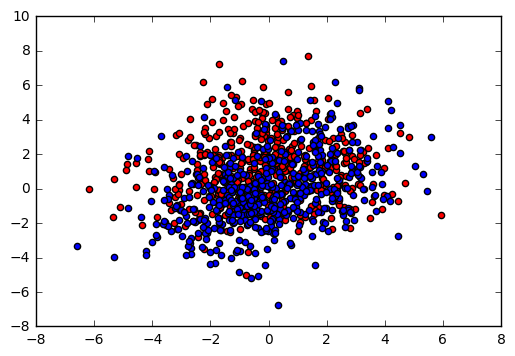

In [57]:
X_dense = X.todense()
plt.scatter(X_dense[np.where(y==0)[0], 0],
            X_dense[np.where(y==0)[0], 1],
            c='red')
plt.scatter(X_dense[np.where(y==1)[0], 0],
            X_dense[np.where(y==1)[0], 1],
            c='blue')
plt.show()

# Implementing Step

#### Inneficient Way

http://sites.stat.psu.edu/~jiali/course/stat597e/notes2/logit.pdf

In [121]:
step.shape

(1001,)

In [123]:
beta_init - step

array([[  -2.14223701, -168.05101455,  100.3121085 , ..., -103.39812125,
         198.87869394, -609.71449813]])

In [108]:
probs = predicted_probabilities(beta_init)
score = score_function(beta_init, probs)
hess = hessian(beta_init, probs)
step = sparse.linalg.inv(hess) * score
W = sparse.eye(X.shape[0]).todok()
for i in range(W.shape[0]):
    W[i,i] = probs[i] * (1 - probs[i])
W = W.tocsc()

In [118]:
z = X * beta_init.T + sparse.linalg.inv(W) * (y - probs)

In [110]:
beta_new = sparse.linalg.inv(X.T * W * X) * X.T * W * z

In [111]:
beta_new.shape

(1001, 1000)

#### Efficient Way

In [69]:
X_tilde = X.copy().todok()

In [81]:
p_one_minus_p = probs * (1-probs)
for k, v in X_tilde.items():
    X_tilde[k] = v * probs[k[0]]

In [99]:
blah = sparse.linalg.inv(X.T * X_tilde) * X.T * (y - probs.ravel())

In [101]:
blah

array([ -14.11066094,  234.96207125,  -38.56310067, ..., -184.38329489,
       -338.4612782 , -402.30135033])

In [39]:
beta_init.shape

(1, 1001)

In [29]:
def newton_step(beta):
    probs = predicted_probabilities(beta)
    score = score_function(beta, probs)
    hess = hessian(beta, probs)
    step = sparse.linalg.inv(hess) * score
    return beta - step

In [35]:
hessian(beta_init, probs)

<1001x1001 sparse matrix of type '<class 'numpy.float64'>'
	with 101877 stored elements in Compressed Sparse Column format>

ValueError: dimension mismatch

In [19]:
y.shape

(1000,)

In [20]:
X.shape

(1000, 1001)

In [25]:
predicted_probabilities(beta_init).shape

(1000, 1)

In [27]:
score_function(beta_init, predicted_probabilities(beta_init)).shape

(1001, 1000)

In [18]:
newton_step(beta_init)

ValueError: dimension mismatch

In [261]:
# def newton_step(beta):
#     exp_log_odds = np.exp(sparse.csr_matrix(beta).dot(X.T).A).T
#     probs = 1 / (1 + exp_log_odds)
#     W = sparse.eye(X.shape[0]).todok()
#     for i in range(W.shape[0]):
#         W[i,i] = probs[i] * (1 - probs[i])
#     neg_hessian = X.T.dot(W).dot(X)
#     z = X.dot(beta_init.T) + sparse.linalg.inv(W).dot(y - probs)
#     return sparse.linalg.inv(neg_hessian).dot(X.T).dot(W).dot(z)

In [262]:
blah = newton_step(beta_init)

/opt/conda/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:96: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/opt/conda/lib/python3.5/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:161: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


(1000, 1000)


In [264]:
blah.shape

(1001, 1000)

In [184]:
sparse.csr_matrix(beta_init).dot(X.T)

array([  2.70204276e+00,   2.76429187e+00,   5.58362425e-01,
        -1.01634160e+00,   1.07875911e+00,  -1.27428309e+00,
        -3.41216610e+00,  -8.40907940e-01,  -5.10143886e-01,
         6.02996776e-01,   8.20434544e-01,  -3.50662067e-01,
         3.97704871e-01,  -4.02708565e-01,   7.75335602e-01,
         5.21886513e-01,  -1.05050392e+00,   3.08184035e-01,
         1.13945349e+00,   2.76649696e+00,  -3.22164883e-01,
         3.54473398e+00,   4.58416638e-01,  -1.91768993e+00,
        -2.33640645e+00,   4.07110326e-01,  -5.81651662e-01,
         1.36781908e+00,   1.84321497e+00,   2.57525525e+00,
        -4.68173934e-01,   2.03939389e+00,   4.15733948e+00,
        -1.45878003e+00,  -3.75799297e+00,  -1.24915746e+00,
        -2.30193874e-01,   9.51198491e-01,  -2.18020335e+00,
        -1.56109670e+00,   6.96663464e-01,   2.17292772e-01,
         1.19367612e+00,   8.05434313e-01,   1.32900854e+00,
         1.53877239e+00,  -7.98181875e-01,   1.44063960e+00,
         4.11104366e+00,

In [19]:
def log_likelihood_multiclass(beta):
    num_classes = len(set(y))
    beta = beta.reshape((num_classes - 1, X.shape[1]))
    ll = 0.
    for n in range(X.shape[0]):
        for j in range(num_classes - 1):
            log_prob_not_event = np.log(np.sum(np.exp(X[n, :].dot(beta.T))))
            if y[n] == j:
                log_prob_event = np.sum(X[n, :].dot(beta.T))
                ll += log_prob_event - log_prob_not_event
            else:
                ll += -log_prob_not_event
    return ll

In [26]:
log_likelihood(beta_init.ravel())

-2777.6104545115936

In [31]:
res = minimize(log_likelihood, beta_init.ravel(), method='L-BFGS-B')

KeyboardInterrupt: 

In [32]:
beta_init.ravel().shape

(2002,)

In [44]:
class SparseLogisticRegression(object):
    
    def __init__(self):
        pass
    
    def blah(self):
        pass

<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 9993 stored elements in Compressed Sparse Row format>